## Calculation of transmutation rates expected for different elements. This is a rough estimate but can be used as a first indication.
### Step-by-step

1. Obtain the cross-sections plot of interest for the element in study, normally those that are bigger impact are (n,$\alpha$) and (n,p) for 14.1 MeV neutrons and (n, $\gamma$) for thermal neutrons.
2. Multiply these cross-section plots with the one with neutron flux at the wall to obtain other two plots that show the **number of reactions by those processes**. This is, one for (n,$\alpha$), one for (n,p) and one for (n, $\gamma$).
3. Knowing the full surface area of the first wall and the thickness of the expected layer calculate the **number of reactions** during a full power year (~9.125 days) and for 20fpy (the full expected duration of ITER operation).
4. Calculate the **percentual loss of material** during the full power year and 20fpy.

In [11]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt

In [12]:
#Read neutron flux at ITER wall
neutron_flux = pd.read_csv('neutron_energy_spectrum.csv', names=['Neutron energy (eV)', 'Neutron flux (n cm-2 s-1)'], 
dtype={'Neutron energy (eV)': float, 'Neutron flux (n cm-2 s-1)': float}).to_numpy()

neutron_flux_function = interp1d(neutron_flux[:,0], neutron_flux[:,1], kind='linear', fill_value="extrapolate")
new_X = 1e6
new_Y = neutron_flux_function(new_X)
formatted_Y = "{:.2e}".format(new_Y)
print(f"For X = {new_X}, interpolated Y = {formatted_Y}")

For X = 1000000.0, interpolated Y = 2.86e+13


### Elemental information

This should display the abudance if the element has isotopes and read the files of the cross section of the reactions with neutrons

In [13]:
Pt194_abundance=0.3286
Pt195_abundance=0.3378
Pt196_abundance=0.2521

Pt194_A = 193.96268 #g/mol
Pt195_A = 194.96477 #g/mol
Pt196_A = 195.96495 #g/mol

rho_Pt = 21.45 #g/cm^3
N_A = 6.022e23 #atoms/mol

avg_A = Pt194_abundance*Pt194_A + Pt195_abundance*Pt195_A + Pt196_abundance*Pt196_A
N_target = (rho_Pt * N_A)/avg_A

PtFolder = ['Pt194', 'Pt195', 'Pt196']
PtArrays = []

In [14]:
for folder in PtFolder:
    folder_data = []
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder, filename)
            # Use pandas to read the CSV file into a DataFrame
            df = pd.read_csv(file_path, skiprows=3, sep=';', names=['Incident energy (eV)', 'Cross-section (b)'], 
            dtype={'Incident energy (eV)': float, 'Cross-section (b)': float})

            # Convert the cross-section values from barns to cm²
            df['Cross-section (b)'] *= 1e-24
            
            # Convert the DataFrame to a numpy array
            data_array = df.to_numpy()
            folder_data.append(data_array)
    PtArrays.append(folder_data)

In [15]:
#First position is of each one of these arrays is (n,$\alpha$), second (n,$\gamma$) and third (n,p)


Pt194_CS = (Pt194_abundance*PtArrays[0][0], Pt194_abundance*PtArrays[0][1], Pt194_abundance*PtArrays[0][2])
Pt195_CS = (Pt195_abundance*PtArrays[1][0], Pt195_abundance*PtArrays[1][1], Pt195_abundance*PtArrays[1][2])
Pt196_CS = (Pt196_abundance*PtArrays[2][0], Pt196_abundance*PtArrays[2][1], Pt196_abundance*PtArrays[2][2])

Pt_isotopes_CS = (Pt194_CS, Pt195_CS, Pt196_CS)

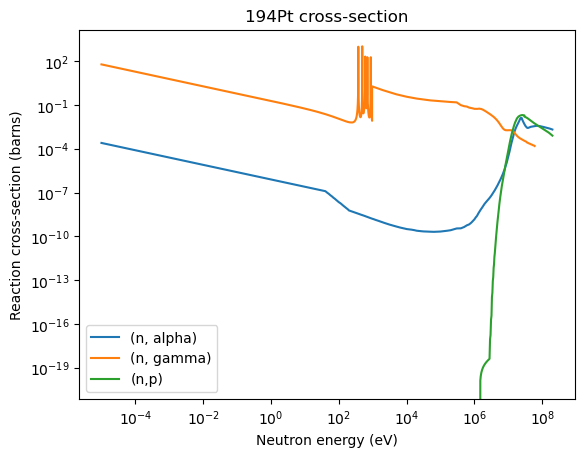

In [16]:
#plt.figure(figsize=(10,6), dpi=200)

Pt194_CS_plot = (PtArrays[0][0], PtArrays[0][1], PtArrays[0][2])
legend = ('(n, alpha)', '(n, gamma)', '(n,p)')
for i in range(len(Pt194_CS_plot)):
    plt.plot(Pt194_CS_plot[i][:,0], Pt194_CS_plot[i][:,1]*1e24, label = legend[i])



plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("194Pt cross-section")
plt.xlabel('Neutron energy (eV)')
plt.ylabel('Reaction cross-section (barns)')

plt.show()

### ITER parameters

In [17]:
first_wall_area = 6e6 #in cm^2
thickness1 = 1 #in cm
thickness2 = 1e-4 #in cm
fpy = 788400 #9.125 days in seconds, a full power year
fpy_full = fpy*20 #in seconds

### Transmutation reaction rate

To calculate the transmutation reaction rate one needs to know the number of nuclei per cm^3, the neutron flux and cross-section of the transmutation reaction, so that:

$R[cm^{-3} s^{-1}] = N[cm^{-3}] \times \sigma[cm^2] \times \Phi[cm^{-2} s^{-1}]$

And if one accounts for the thickness $\delta$, surface area of the first wall $A_{FW}$ and full power year $t_{fpy}$. 

$N_R = N[cm^{-3}] \times \sigma[cm^2] \times \Phi[cm^{-2} s^{-1}] \times A_{FW}[cm^2] \times \delta[cm] \times t_{fpy}[s]$

With this, multiplying by the total volume of the first wall layer, whether that'd be a coating or bulk, we obtain the number of reactions per second. Then, multiplying by the fpy in seconds, one can calculate the number of transmutation reactions per full power year. Assuming a wall made of 100% of the material of study, we can compare the number of new transmutated atoms with the number of original atoms and compare how many of the original atoms transmutated. There are two transmutation reaction values, the first being associated with total transmutation rate, including isotopes, the second and more important is the number of new atoms.

Some important concepts that this code misses are:

- No transportation code, assumes a constant flux at the wall based on the DT campaign at full power.
- Assumes constant thickness of the wall throught its surface area.
- Each neutron that penetrates the wall has always the same probability, the sum of each probabilty of each reaction along the thickness.
- There's no dynamic calculations, this is, accounting for the new nuclei as they are formed.

These first three parameters can overstimate the number of reactions. In general, the probability of the reaction (cross-section) is quite low, but multiplied by the high flux, it reaches significant values. The same neutron can only have one reaction (of the ones considered, since scattering is not included). Therefore, generally, this code overestimates the total transmutation rate that includes isotopes but is quite good for the estimation of the transmutation rate that changes the atomic number. The last parameter is harder to account for.

In [18]:
total_sum = 0
trans_sum = 0
j = 0
total_atoms = N_target*first_wall_area*thickness2
for isotope in Pt_isotopes_CS:
    for reaction in isotope:
        #cross-section*flux*Ntarget*first_wall_area*thickness*full_power_year
        arr = reaction[:,1]*neutron_flux_function(reaction[:,0])*total_atoms*fpy

        mask = arr>=0
        filtered_array = arr[mask]
        sum = np.sum(filtered_array)
        total_sum += sum
        if j in [0,2]:
            trans_sum+=sum
        j+=1

    #print('Total transmutation =', total_sum)
    #print('Total transmutation w/ isotopes =', trans_sum)



print('Percentage of transmutated atoms =', total_sum/total_atoms*100, '%')
print('Percentage of transmutated atoms without isotopes =', trans_sum/total_atoms*100, '%')

Percentage of transmutated atoms = 85.98635590957242 %
Percentage of transmutated atoms without isotopes = 0.001038195143321873 %
